In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xarray as xr
from scipy.interpolate import griddata
from scipy.stats import circmean
from shapely import Polygon
import regionmask
import geopandas as gpd

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# BARRA

In [3]:
def open_files(variable,lat_start,lat_end,lon_start,lon_end):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"
            ] #"202203-202203","202204-202204": removed as not in radar domain; barra goes back to 2007 (radar till 08-2011)
    fp = "/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/1hr/"+variable+"/"
    data = []
    for months in list:
        # to get specific hour, edit: u.ua850.isel(time=(barra2_202201.time.dt.hour == hour)
        var = xr.open_dataset(fp+variable+"_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_1hr_"+months+".nc", engine="h5netcdf",chunks="auto")#{'time':-1})
        mean = var[variable].sel(lat=slice(lat_start,lat_end),lon=slice(lon_start,lon_end))
        var_mean = mean.mean(dim=["lat","lon"])    
        data.append(var_mean)
    return data

In [4]:
%%time
# wind_mean_u = open_files("ua850",-20.768799,-18.0708,145.12054,147.9812) #townsville
# wind_mean_v = open_files("va850",-20.768799,-18.0708,145.12054,147.9812) #townsville
wind_mean_u = open_files("ua850",-18.165955,-15.468018,144.27374,147.09222) #cairns
wind_mean_v = open_files("va850",-18.165955,-15.468018,144.27374,147.09222) #cairns
# wind_mean_uw = open_files("ua850",-17.636353,-14.938416,148.55927,151.36993) #willis island
# wind_mean_vw = open_files("va850",-17.636353,-14.938416,148.55927,151.36993) #willis island

0.3.0
CPU times: user 8.07 s, sys: 4.1 s, total: 12.2 s
Wall time: 29.7 s


In [5]:
%%time
concat_u = xr.concat(wind_mean_u,"time")
concat_v = xr.concat(wind_mean_v,"time")
# concat_uw = xr.concat(wind_mean_uw,"time")
# concat_vw = xr.concat(wind_mean_vw,"time")

CPU times: user 121 ms, sys: 6.55 ms, total: 127 ms
Wall time: 126 ms


In [6]:
%%time
uu = (concat_u * units("m/s")).compute()
vv = (concat_v * units("m/s")).compute()
# uuw = (concat_uw * units("m/s")).compute()
# vvw = (concat_vw * units("m/s")).compute()

CPU times: user 18min 6s, sys: 1min 17s, total: 19min 24s
Wall time: 28min 11s


In [7]:
%%time
wind_dir = metpy.calc.wind_direction(uu,vv,convention='from')
wind_speed = metpy.calc.wind_speed(uu,vv)
# wind_dirw = metpy.calc.wind_direction(uuw,vvw,convention='from')
# wind_speedw = metpy.calc.wind_speed(uuw,vvw)

CPU times: user 8.65 ms, sys: 1.81 ms, total: 10.5 ms
Wall time: 9.18 ms


In [10]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
# print('Mean BARRA2 Townsville wind direction: ',calc_mean_wdir(wind_dir))
print('Mean BARRA2 cairns wind direction: ',calc_mean_wdir(wind_dir))

Mean BARRA2 cairns wind direction:  110.81416388682412


# open radar

In [8]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="h5netcdf", chunks="auto") #={'time':-1})

In [9]:
%%time
# open radar ds
# ds_radar_T = open_radar_ds("73")
ds_radar_C = open_radar_ds("19")
# ds_radar_W = open_radar_ds("41")

CPU times: user 2min 27s, sys: 6.33 s, total: 2min 34s
Wall time: 7min 29s


In [10]:
%%time
# ds_radar_T = ds_radar_T.persist()
ds_radar_C = ds_radar_C.persist()
# ds_radar_W = ds_radar_W.persist()

CPU times: user 8min 10s, sys: 6min 56s, total: 15min 6s
Wall time: 15min 25s


# make a transect 

In [13]:
# polygon for cairns
polygon = Polygon([
            (-150000, -70000),
            (-145000, -75000),
            (145000, 100000),
            (140000, 105000),
        ])
# polygon for townsville
# polygon = Polygon([
#             (-125000, -105000),
#             (-120000, -110000),
#             (145000, 95000),
#             (140000, 100000),
#         ])
gdf = gpd.GeoDataFrame({'geometry': [polygon]})
mask = regionmask.mask_geopandas(gdf, ds_radar_C.x, ds_radar_C.y,wrap_lon=False) # change C or T
masked_ds = ds_radar_C.rainrate.where(~mask.isnull()) # change C or T
mean_rr = masked_ds.mean(dim='time')
masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
mask_ds = ds_radar_C.rainrate.where(~masked_beam_blockage.isnull()) # change for C or T

Text(0.5, 1.0, 'Cairns Hovmöller Transect')

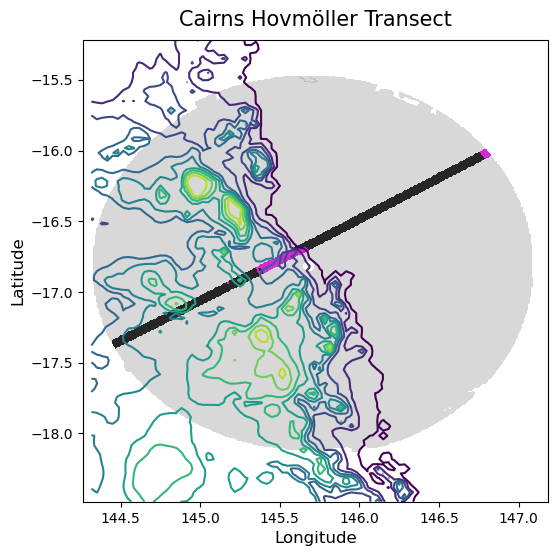

In [16]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(ds_bath['x'].data), max(ds_bath['x'].data), len(ds_bath['x'].data))
lat = np.linspace(min(ds_bath['y'].data), max(ds_bath['y'].data), len(ds_bath['y'].data))
lon, lat = np.meshgrid(lon, lat)
dem = ds_bath['z'].data

fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.patch.set_facecolor('white')
# changing between mask and masked_ds (bb with or without)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), masked_ds.mean(dim='time'),levels=1,colors="magenta",alpha=1)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), mask_ds.mean(dim='time'),levels=1,colors="black",alpha=1)
ax.contourf(ds_radar_C.longitude.isel(time=0), ds_radar_C.latitude.isel(time=0), ds_radar_C.rainrate.mean(dim=['time']),levels=1,colors='grey',alpha=0.3)
# ax.contour(lon,lat,dem,levels=10,extend="both",cmap='binary')
sel_lat_lon = ds_bath["z"].sel(x=slice(144.3,147.2),y=slice(-18.5,-15.2)) #towns:x=slice(145,148.2),y=slice(-21,-17.8)
cmapc = plt.get_cmap('viridis')
sel_lat_lon.plot.contour(levels=10,ax=ax, cmap=cmapc,alpha=1,vmin=0)

ax.set_ylabel("Latitude",fontsize=12)
ax.set_xlabel("Longitude",fontsize=12)
ax.set_title("Cairns Hovmöller Transect",fontsize=15,pad=10)

# Mask coastal radars - above is better method

In [133]:
# Use climatological average to mask out effects of beam blockage
def bb_mask(ds,towns=None):
    radar_mean = ds.rainrate.mean(dim=["time"],skipna=True)
    if towns==True:
        masked_beam_blockage = xr.where((radar_mean < 1), np.nan,radar_mean) # threshold for Townsville: 1mm/h rain rate mean
    else:
        masked_beam_blockage = xr.where((radar_mean < 1.5), np.nan,radar_mean) # threshold for Cairns: 1.5mm/h rain rate mean
        masked_beam_blockage = xr.where((radar_mean > 5), np.nan,masked_beam_blockage) # removing strange artifacts on edge of radar field
    return masked_beam_blockage
cairns_bb_mask = bb_mask(ds_radar_C,towns=False)
masked = ds_radar_C.rainrate.where(cairns_bb_mask)
equation_y = 2 * cairns_bb_mask.x
# # mask data based on lineplot
selected_data = ds_radar_C.rainrate.where(cairns_bb_mask.y == equation_y)
# cairns_bb_mask.where(cairns_bb_mask.y == equation_y)
selected_data = ds_radar_C.rainrate.where(cairns_bb_mask.y == np.arange(-150,151,2))


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (301,) and arg 1 with shape (151,).

# Hovmöller - all times in ds

In [17]:
def hov_diurnal_no_winds(ds,masked_ds,bb_ds,lat,coastline=None):
    if coastline==True:
        hourly_grouped_rr = masked_ds.groupby(masked_ds.time.dt.hour) # without beam blockage
        hourly_grouped_rr_bb = bb_ds.groupby(bb_ds.time.dt.hour) # beam blockage is removed in the masked_ds
    else:
        hourly_grouped_rr = ds.rainrate.isel(y=lat).groupby(ds.time.dt.hour)
    diurnal_rr_all = []
    diurnal_rr_all_bb = []
    for hours in np.arange(0,24,1):
        rr_mean = hourly_grouped_rr[hours].mean(dim=["time",'y'],skipna=True) 
        rr_mean_bb = hourly_grouped_rr_bb[hours].mean(dim=["time",'y'],skipna=True) 
        print(hours)
        diurnal_rr_all.append(rr_mean.values) 
        diurnal_rr_all_bb.append(rr_mean_bb.values) 
    return diurnal_rr_all,diurnal_rr_all_bb

In [18]:
t_hov,t_hov_bb = hov_diurnal_no_winds(ds_radar_C,masked_ds,mask_ds,120,coastline=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [28]:
hov_aest = np.roll(t_hov, shift=10,axis=0)
hov_aest_bb = np.roll(t_hov_bb, shift=10,axis=0)

clipped = []
for i in np.arange(0,24,1):
    hours=hov_aest[i]
    clipped.append(hours[19:269])
clipped_bb = []
for i in np.arange(0,24,1):
    hours=hov_aest_bb[i]
    clipped_bb.append(hours[19:269])

In [29]:
clipped

[array([2.85931   , 2.9431424 , 3.0169647 , 3.1073732 , 3.0282102 ,
        3.0617552 , 3.0807874 , 3.0700803 , 3.048197  , 2.9177456 ,
        2.8743348 , 2.7356663 , 2.6067245 , 2.4716835 , 2.3993263 ,
        2.3684447 , 2.3510385 , 2.3526552 , 2.3291318 , 2.3290513 ,
        2.2094038 , 2.0608313 , 2.01283   , 1.9593736 , 1.92012   ,
        1.8350588 , 1.796302  , 1.805134  , 1.8761829 , 1.906821  ,
        1.9631573 , 1.9879178 , 2.0203838 , 1.9123691 , 1.8996598 ,
        1.7283909 , 1.5436047 , 1.4854239 , 1.375167  , 1.3588043 ,
        1.3444159 , 1.2569934 , 1.266094  , 1.3749894 , 1.4335508 ,
        1.3366468 , 1.309241  , 1.4114974 , 1.4858177 , 1.4194682 ,
        1.4140978 , 1.2928509 , 1.2370083 , 1.1361773 , 1.0518507 ,
        1.0836495 , 1.1239127 , 1.1868902 , 1.155705  , 1.0627137 ,
        0.992     , 0.9486762 , 0.95539945, 1.060899  , 1.2667207 ,
        1.4312938 , 1.6741745 , 1.7053307 , 1.6755605 , 1.5374132 ,
        1.4198846 , 1.2123296 , 1.1009963 , 0.91

Text(175, 1, 'n=1262 days')

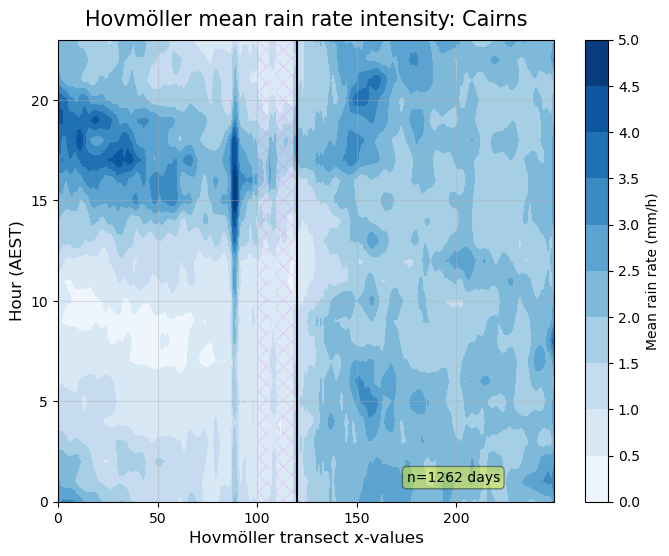

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
fig.patch.set_facecolor('white')
levels=np.arange(0,5.5,0.5)
cf=ax.contourf(np.arange(0,250,1), np.arange(0,24,1), clipped, levels=levels,cmap="Blues",alpha=1)
hatch=ax.fill_between([0, 1], 0, 1,color='magenta', facecolor='white', alpha=0.1, hatch='x', transform=ax.transAxes)
hatch.set_hatch('x'*2)
cf_bb=ax.contourf(np.arange(0,250,1), np.arange(0,24,1), clipped_bb, levels=levels,cmap="Blues",alpha=1) # beam blockage regions are removed
cbar=plt.colorbar(cf,label="Mean rain rate (mm/h)")
cbar.set_ticks(np.arange(0,5.5,0.5))
dashed=[]
for i in np.arange(0,24,1):
    dashed.append(120)
ax.plot(dashed,np.arange(0,24,1),color='black',linestyle='-')
ax.grid(alpha=0.4)
ax.set_ylabel("Hour (AEST)",fontsize=12)
ax.set_xlabel("Hovmöller transect x-values",fontsize=12)
ax.set_title("Hovmöller mean rain rate intensity: Cairns",fontsize=15,pad=10)
plt.annotate("n=1262 days",(175,1),bbox=dict(boxstyle='round', fc='yellow',alpha=0.4, ec='black'))

# Hovmöller - wind regimes composites

In [14]:
def hov_diurnal_winds(wind_dir1,wind_dir2,ds,lat,coastline=None):
    # select wind directions
    wind = wind_dir[(wind_dir>wind_dir1*units("degree"))&(wind_dir<wind_dir2*units("degree"))]
  
    # Define the time window of 30 minutes - to select radar data +30/-30min of selected BARRA2 wind direction hour
    window_size = pd.Timedelta(minutes=30)
    selected_data = []
    # Loop through each time point in wind (directions chosen above)
    for time in wind['time']: 
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        # Select the data within the time window from ds2 using slice
        data_within_window = ds.rainrate.sel(time=slice(window_start, window_end)) #add in ds.rainrate for willis

        selected_data.append(data_within_window)
    # Concatenate the selected data into a single xarray dataset
    radar_composite_winds = xr.concat(selected_data, dim='time')
    print(len(radar_composite_winds))
    # cairns and townsville
    if coastline==True:
        polygon = Polygon([   # cairns
                    (-150000, -70000),
                    (-145000, -75000),
                    (145000, 100000),
                    (140000, 105000),
                ])
        # polygon = Polygon([ # townsville
        #     (-125000, -105000),
        #     (-120000, -110000),
        #     (145000, 95000),
        #     (140000, 100000),
        # ])
        gdf = gpd.GeoDataFrame({'geometry': [polygon]})
        mask = regionmask.mask_geopandas(gdf, ds.x, ds.y,wrap_lon=False)
        masked_ds = ds.rainrate.where(~mask.isnull())
        mean_rr = masked_ds.mean(dim='time')
        masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # threshold is 1.2 for cairns, 0.8 for towns
        mask_ds = radar_composite_winds.where(~masked_beam_blockage.isnull())
        hourly_grouped_rr = masked_ds.groupby(masked_ds.time.dt.hour)
        hourly_grouped_rr_bb = mask_ds.groupby(mask_ds.time.dt.hour)
        diurnal_rr_all = []
        diurnal_rr_all_bb = []
        for hours in np.arange(0,24,1):
            rr_mean = hourly_grouped_rr[hours].mean(dim=["time",'y'],skipna=True) 
            rr_mean_bb = hourly_grouped_rr_bb[hours].mean(dim=["time",'y'],skipna=True) 
            print(hours)
            diurnal_rr_all.append(rr_mean.values) 
            diurnal_rr_all_bb.append(rr_mean_bb.values) 
    else:
        hourly_grouped_rr = radar_composite_winds.isel(y=lat).groupby(radar_composite_winds.time.dt.hour)
        diurnal_rr_all = []
        for hours in np.arange(0,24,1):
            rr_mean = hourly_grouped_rr[hours].mean(dim=["time"],skipna=True) 
            print(hours)
            diurnal_rr_all.append(rr_mean.values) 
    return diurnal_rr_all,diurnal_rr_all_bb

In [15]:
t_ne,t_ne_bb = hov_diurnal_winds(0,90,ds_radar_C,120,coastline=True)
t_se,t_se_bb = hov_diurnal_winds(90,180,ds_radar_C,120,coastline=True)
t_sw,t_sw_bb = hov_diurnal_winds(180,270,ds_radar_C,120,coastline=True)
t_nw,t_nw_bb = hov_diurnal_winds(270,360,ds_radar_C,120,coastline=True)

34890
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
176961
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
31717
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24913
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [16]:
t_e,t_e_bb = hov_diurnal_winds(0,120,ds_radar_C,120,coastline=True)

116178
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [17]:
t_w,t_w_bb = hov_diurnal_winds(120,330,ds_radar_C,120,coastline=True)

145391
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [19]:
t_ne_aest = np.roll(t_ne, shift=10,axis=0)
t_se_aest = np.roll(t_se, shift=10,axis=0)
t_sw_aest = np.roll(t_sw, shift=10,axis=0)
t_nw_aest = np.roll(t_nw, shift=10,axis=0)
t_e_aest = np.roll(t_e, shift=10,axis=0)
t_w_aest = np.roll(t_w, shift=10,axis=0)
# bb versions
t_ne_aest_bb = np.roll(t_ne_bb, shift=10,axis=0)
t_se_aest_bb = np.roll(t_se_bb, shift=10,axis=0)
t_sw_aest_bb = np.roll(t_sw_bb, shift=10,axis=0)
t_nw_aest_bb = np.roll(t_nw_bb, shift=10,axis=0)
t_e_aest_bb = np.roll(t_e_bb, shift=10,axis=0)
t_w_aest_bb = np.roll(t_w_bb, shift=10,axis=0)
# clipping to remove nans so that nans aren't plotted (the edge of the CAPPI grids)
clipped_ne = []
clipped_se = []
clipped_sw = []
clipped_nw = []
clipped_ne_bb = []
clipped_se_bb = []
clipped_sw_bb = []
clipped_nw_bb = []
clipped_e = []
clipped_w = []
clipped_e_bb = []
clipped_w_bb = []
for i in np.arange(0,24,1):
    hours1=t_ne_aest[i]
    clipped_ne.append(hours1[19:269])#17:275])   #towns:36:277
    hours2=t_se_aest[i]
    clipped_se.append(hours2[19:269])
    hours3=t_sw_aest[i]
    clipped_sw.append(hours3[19:269])
    hours4=t_nw_aest[i]
    clipped_nw.append(hours4[19:269])
    # beam blocked
    hours5=t_ne_aest_bb[i]
    clipped_ne_bb.append(hours5[19:269])
    hours6=t_se_aest_bb[i]
    clipped_se_bb.append(hours6[19:269])
    hours7=t_sw_aest_bb[i]
    clipped_sw_bb.append(hours7[19:269])
    hours8=t_nw_aest_bb[i]
    clipped_nw_bb.append(hours8[19:269])
    # east and west
    hours9=t_w_aest[i]
    clipped_w.append(hours9[19:269])
    hours10=t_e_aest[i]
    clipped_e.append(hours10[19:269])
    # e and w bb
    hours11=t_e_aest_bb[i]
    clipped_e_bb.append(hours11[19:269])
    hours12=t_w_aest_bb[i]
    clipped_w_bb.append(hours12[19:269])

Text(175, 1, 'n=114 days')

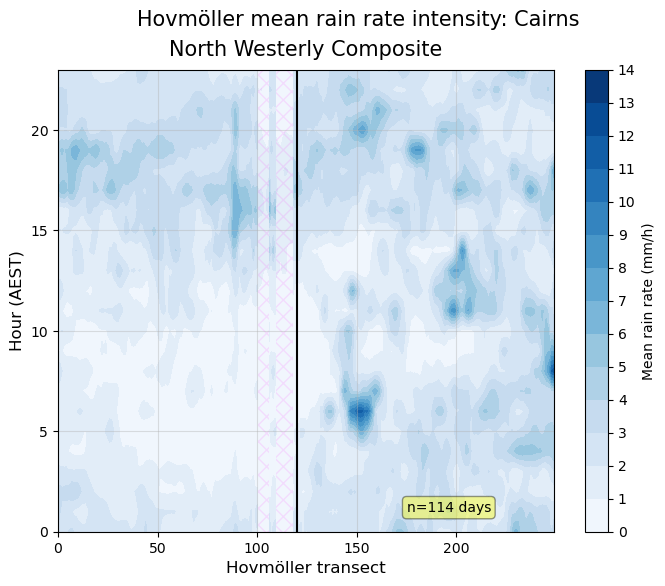

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
fig.patch.set_facecolor('white')
levels=np.arange(0,15,1)
cf=ax.contourf(np.arange(0,250,1), np.arange(0,24,1), clipped_nw, levels=levels,cmap="Blues",alpha=1)
hatch=ax.fill_between([0, 1], 0, 1,color='magenta', facecolor='white', alpha=0.1, hatch='x', transform=ax.transAxes)
hatch.set_hatch('x'*2)
cf_bb=ax.contourf(np.arange(0,250,1), np.arange(0,24,1), clipped_nw_bb, levels=levels,cmap="Blues",alpha=1) # beam blockage regions are removed
cbar=plt.colorbar(cf,label="Mean rain rate (mm/h)")
cbar.set_ticks(np.arange(0,15,1))
dashed=[]
for i in np.arange(0,24,1):
    dashed.append(120) #157
ax.plot(dashed,np.arange(0,24,1),color='black',linestyle='-')
ax.grid(alpha=0.4)
ax.set_ylabel("Hour (AEST)",fontsize=12)
ax.set_xlabel("Hovmöller transect",fontsize=12)
plt.suptitle('Hovmöller mean rain rate intensity: Cairns',fontsize=15)
ax.set_title("North Westerly Composite",fontsize=15,pad=10)
plt.annotate("n=114 days",(175,1),bbox=dict(boxstyle='round', fc='yellow',alpha=0.4, ec='black'))